/tmp/ipython-input-2868499452.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2025-01-01', end='2025-12-31 23:00:00', freq='H')


Estadísticas del Año:
       Temp_Exterior  Temp_Interior    Temp_Agua
count    8760.000000    8760.000000  8760.000000
mean       21.913022      22.968090    19.607221
std         8.043221       4.053420     0.630948
min         3.600242      13.189050    17.575688
25%        15.495919      19.752838    19.335715
50%        21.915446      22.970749    20.000000
75%        28.325844      26.171573    20.000000
max        40.536291      33.205579    20.000000


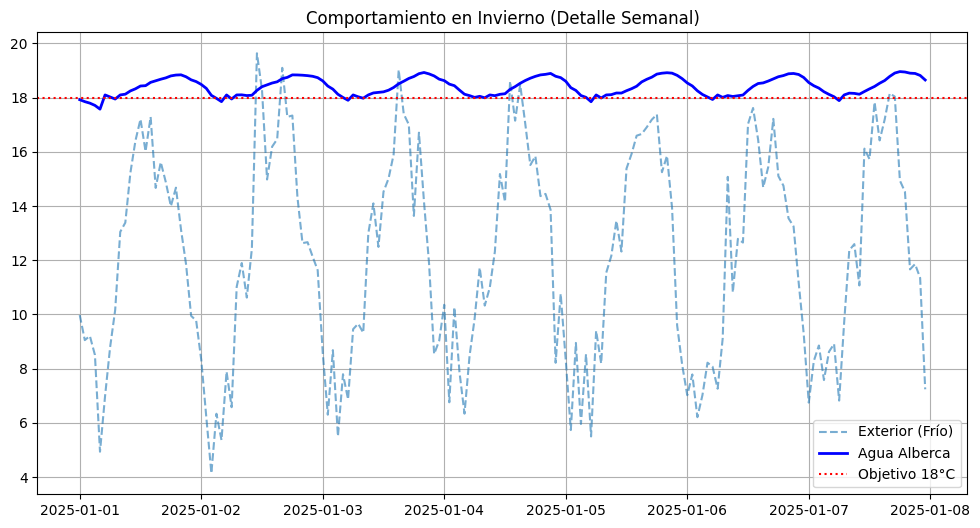


Archivo 'datos_alberca_iot.csv' generado exitosamente.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE LA SIMULACIÓN ---
# Rango: Un año completo, frecuencia horaria
dates = pd.date_range(start='2025-01-01', end='2025-12-31 23:00:00', freq='H')
df = pd.DataFrame(index=dates)
df['Month'] = df.index.month
df['Hour'] = df.index.hour
df['DayOfYear'] = df.index.dayofyear

# --- 1. SIMULACIÓN TEMPERATURA EXTERIOR (AMBIENTE) ---
# Objetivo: Promedio ~21.9°C, Mínima cercana a 1.3°C durante heladas de invierno
# Usamos ondas senoidales para el ciclo anual y diario + ruido aleatorio

avg_temp_target = 21.9
# Onda Anual: Más frío a inicio/fin de año, más calor a mitad (Día 200 aprox)
yearly_cycle = -10 * np.cos(2 * np.pi * (df['DayOfYear'] - 15) / 365)
# Onda Diaria: Más frío a las 4am, más calor a las 3pm
daily_cycle = 5 * np.cos(2 * np.pi * (df['Hour'] - 15) / 24)
# Ruido natural
noise = np.random.normal(0, 1.5, len(df))

# Temperatura Exterior Final
df['Temp_Exterior'] = avg_temp_target + yearly_cycle + daily_cycle + noise

# --- 2. SIMULACIÓN TEMPERATURA INTERIOR (CUARTO DE ALBERCA) ---
# El cuarto tiene insolación térmica. Es más estable que afuera.
# Fórmula: Influencia exterior atenuada + Base del edificio
df['Temp_Interior'] = (df['Temp_Exterior'] * 0.5) + 12 + np.random.normal(0, 0.5, len(df))
# Restricción: El edificio no baja de 10°C (aislamiento/calefacción central)
df['Temp_Interior'] = df['Temp_Interior'].apply(lambda x: max(x, 10.0))

# --- 3. SIMULACIÓN TEMPERATURA AGUA (CONTROL AUTO. DE CALDERA) ---
water_temp = []
heater_status = [] # 1 = ON, 0 = OFF
current_water = 18.0 # Condición inicial ideal

# Parámetros del sistema
TARGET_TEMP = 18.0
MAX_SUMMER_TEMP = 20.0
HEATING_RATE = 2.0      # Grados que sube por hora encendido
COOLING_FACTOR = 0.05   # Tasa de pérdida de calor hacia el ambiente

for i in range(len(df)):
    row = df.iloc[i]
    hour = row['Hour']
    indoor_t = row['Temp_Interior']

    # Cambio natural (Ley de enfriamiento de Newton simplificada)
    # Si Agua > Interior -> Se enfría. Si Interior > Agua (Verano) -> Se calienta.
    delta = current_water - indoor_t
    natural_change = -delta * COOLING_FACTOR

    # Lógica de Control
    # Horario Alberca: 08:00 a 20:00
    # Pre-calentamiento: 05:00 a 08:00 (Para asegurar 18°C al abrir)
    is_active_hours = (hour >= 5) and (hour <= 20)

    heater_on = 0
    change = natural_change

    if is_active_hours:
        # Si estamos por debajo del objetivo, ENCENDER CALDERA
        if current_water < TARGET_TEMP:
            heater_on = 1
            # La caldera suma calor a la pérdida natural
            change = HEATING_RATE + natural_change
            # Evitar overshoot (no pasarse de golpe)
            if current_water + change > TARGET_TEMP:
                change = TARGET_TEMP - current_water + 0.1
        else:
            # Si ya estamos en 18°C o más
            # En verano, si el ambiente está caliente, permitimos subir hasta 20°C
            if indoor_t > current_water:
                # Dejar que suba naturalmente pero topar en 20°C
                if current_water + natural_change > MAX_SUMMER_TEMP:
                    change = 0 # Mantener
    else:
        # Fuera de horario (Noche 21:00 - 04:00)
        # Dejar enfriar, PERO evitar que baje de 13°C (protección sistema)
        if current_water < 14.0:
            heater_on = 1 # Mantenimiento mínimo
            change = HEATING_RATE + natural_change

    current_water += change

    # Asegurar límites físicos duros
    if current_water > MAX_SUMMER_TEMP: current_water = MAX_SUMMER_TEMP

    water_temp.append(current_water)
    heater_status.append(heater_on)

df['Temp_Agua'] = water_temp
df['Caldera_ON'] = heater_status

# --- 4. RESULTADOS Y VISUALIZACIÓN ---
print("Estadísticas del Año:")
print(df[['Temp_Exterior', 'Temp_Interior', 'Temp_Agua']].describe())

# Graficar un fragmento de invierno (Enero) para ver el pre-calentamiento
plt.figure(figsize=(12, 6))
subset = df['2025-01-01':'2025-01-07'] # Primera semana de enero
plt.plot(subset.index, subset['Temp_Exterior'], '--', label='Exterior (Frío)', alpha=0.6)
plt.plot(subset.index, subset['Temp_Agua'], 'b-', linewidth=2, label='Agua Alberca')
plt.axhline(18, color='r', linestyle=':', label='Objetivo 18°C')
plt.title('Comportamiento en Invierno (Detalle Semanal)')
plt.legend()
plt.grid(True)
plt.show()

# Guardar a CSV para el siguiente paso (Web Semántica)
df.to_csv('datos_alberca_iot.csv')
print("\nArchivo 'datos_alberca_iot.csv' generado exitosamente.")

In [ ]:
# 1. Instalar la librería necesaria (si no está instalada)
!pip install rdflib pandas

import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import XSD, RDFS

# 2. Cargar tus datos simulados
df = pd.read_csv('datos_alberca_iot.csv', index_col=0)

# Para agilizar el ejemplo y no hacer un archivo gigante,
# tomaremos una muestra representativa (ej. cada 4 horas)
# o un mes específico si prefieres.
# Para el entregable final, si te piden TODO el año, comenta la siguiente línea.
df_sample = df.iloc[::4] # "Downsampling" para pruebas rápidas

# 3. Inicializar el Grafo y los Namespaces (Ontologías)
g = Graph()

# Definir vocabularios estándar (SOSA, SSN, QUDT para unidades)
SOSA = Namespace("http://www.w3.org/ns/sosa/")
SSN = Namespace("http://www.w3.org/ns/ssn/")
EX = Namespace("http://iot-assist-rmac.moe/iot-alberca/") # Tu namespace propio
QUDT = Namespace("http://qudt.org/schema/qudt/")
UNIT = Namespace("http://qudt.org/vocab/unit/")

g.bind("sosa", SOSA)
g.bind("ssn", SSN)
g.bind("ex", EX)
g.bind("qudt", QUDT)
g.bind("unit", UNIT)

# 4. Crear las Entidades Estáticas (La "Infraestructura")
# La Plataforma (El lugar físico)
alberca_platform = EX.AlbercaUDLAP
g.add((alberca_platform, RDF.type, SOSA.Platform))
g.add((alberca_platform, RDFS.label, Literal("Alberca Techada UDLAP")))

# Definir los Sensores
sensor_agua = EX.SensorAgua01
sensor_interior = EX.SensorAmbienteInt01
sensor_exterior = EX.SensorAmbienteExt01
caldera = EX.CalderaPrincipal

# Propiedades del Sensor de Agua
g.add((sensor_agua, RDF.type, SOSA.Sensor))
g.add((sensor_agua, SOSA.hosts, alberca_platform)) # El sensor está en la alberca
g.add((sensor_agua, SOSA.observes, EX.WaterTemperature)) # Mide temp agua

# Propiedades del Sensor Interior
g.add((sensor_interior, RDF.type, SOSA.Sensor))
g.add((sensor_interior, SOSA.hosts, alberca_platform))
g.add((sensor_interior, SOSA.observes, EX.IndoorTemperature))

# Propiedades del Sensor Exterior
g.add((sensor_exterior, RDF.type, SOSA.Sensor))
g.add((sensor_exterior, SOSA.hosts, alberca_platform))
g.add((sensor_exterior, SOSA.observes, EX.OutdoorTemperature))

# Propiedades de la Caldera (Actuador)
g.add((caldera, RDF.type, SOSA.Actuator))
g.add((caldera, SOSA.hosts, alberca_platform))

print("Infraestructura semántica creada. Procesando observaciones...")

# 5. Loop para convertir datos (CSV) a Tripletas RDF
# Recorremos el DataFrame fila por fila
for index, row in df_sample.iterrows():
    timestamp = row.name # La fecha es el índice
    time_literal = Literal(timestamp, datatype=XSD.dateTime)

    # --- Observación: Temperatura Agua ---
    obs_agua_uri = EX[f"Obs_Agua_{index.replace(' ', 'T')}"]
    g.add((obs_agua_uri, RDF.type, SOSA.Observation))
    g.add((obs_agua_uri, SOSA.madeBySensor, sensor_agua))
    g.add((obs_agua_uri, SOSA.resultTime, time_literal))
    g.add((obs_agua_uri, SOSA.hasSimpleResult, Literal(row['Temp_Agua'], datatype=XSD.float)))
    g.add((obs_agua_uri, SOSA.observedProperty, EX.WaterTemperature))

    # --- Observación: Temperatura Interior ---
    obs_int_uri = EX[f"Obs_Int_{index.replace(' ', 'T')}"]
    g.add((obs_int_uri, RDF.type, SOSA.Observation))
    g.add((obs_int_uri, SOSA.madeBySensor, sensor_interior))
    g.add((obs_int_uri, SOSA.resultTime, time_literal))
    g.add((obs_int_uri, SOSA.hasSimpleResult, Literal(row['Temp_Interior'], datatype=XSD.float)))

    # --- Observación: Temperatura Exterior ---
    obs_ext_uri = EX[f"Obs_Ext_{index.replace(' ', 'T')}"]
    g.add((obs_ext_uri, RDF.type, SOSA.Observation))
    g.add((obs_ext_uri, SOSA.madeBySensor, sensor_exterior))
    g.add((obs_ext_uri, SOSA.resultTime, time_literal))
    g.add((obs_ext_uri, SOSA.hasSimpleResult, Literal(row['Temp_Exterior'], datatype=XSD.float)))

    # --- Actuación: Estado de la Caldera ---
    # Solo registramos si cambió de estado o si está activa, para no saturar.
    # Por simplicidad, registramos el estado actual.
    act_uri = EX[f"Act_Caldera_{index.replace(' ', 'T')}"]
    g.add((act_uri, RDF.type, SOSA.Actuation))
    g.add((act_uri, SOSA.madeByActuator, caldera))
    g.add((act_uri, SOSA.resultTime, time_literal))
    # 1 = Encendido, 0 = Apagado
    estado = "ON" if row['Caldera_ON'] == 1 else "OFF"
    g.add((act_uri, SOSA.hasSimpleResult, Literal(estado)))

# 6. Guardar el Grafo en archivo .ttl (Turtle)
output_file = "grafo_alberca_iot.ttl"
g.serialize(destination=output_file, format="turtle")

print(f"¡Listo! Archivo '{output_file}' generado.")
print(f"Total de tripletas generadas: {len(g)}")

Infraestructura semántica creada. Procesando observaciones...
¡Listo! Archivo 'grafo_alberca_iot.ttl' generado.
Total de tripletas generadas: 37243


In [ ]:
# CÓDIGO PARA VALIDACIÓN CON SPARQL
import rdflib

# 1. Cargar tu grafo generado
g = rdflib.Graph()
g.parse("grafo_alberca_iot.ttl", format="turtle")

print(f"Grafo cargado exitosamente con {len(g)} tripletas.")

# 2. Consulta SPARQL: Detectar anomalías en Verano
# "Dime fecha, hora y temperatura del agua cuando superó los 19.5°C"
query_final = """
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
# AQUÍ ESTÁ LA CORRECCIÓN IMPORTANTE:
PREFIX ex: <http://iot-assist-rmac.moe/iot-alberca/>

SELECT ?time ?tempAgua
WHERE {
    ?obs a sosa:Observation ;
         sosa:observedProperty ex:WaterTemperature ;
         sosa:hasSimpleResult ?tempAgua ;
         sosa:resultTime ?time .

    # Filtramos temperaturas altas (Verano)
    FILTER (?tempAgua > 19.0)
}
ORDER BY DESC(?tempAgua)
LIMIT 10
"""

results = g.query(query_final)

print(f"\n--- RESULTADOS SPARQL: Picos de Temperatura (>19.0°C) ---")
print(f"{'FECHA Y HORA':<25} | {'TEMP AGUA':<15}")
print("-" * 45)

if len(results) == 0:
    print("No se encontraron resultados. Intenta bajar el filtro a > 18.0")
else:
    for row in results:
        # Formateamos para que se vea limpio
        val = float(row.tempAgua)
        print(f"{row.time:<25} | {val:.2f} °C")

Grafo cargado exitosamente con 37243 tripletas.

--- RESULTADOS SPARQL: Picos de Temperatura (>19.0°C) ---
FECHA Y HORA              | TEMP AGUA      
---------------------------------------------
2025-03-24T00:00:00       | 20.00 °C
2025-04-02T00:00:00       | 20.00 °C
2025-04-04T00:00:00       | 20.00 °C
2025-04-05T00:00:00       | 20.00 °C
2025-04-10T00:00:00       | 20.00 °C
2025-04-11T00:00:00       | 20.00 °C
2025-04-12T00:00:00       | 20.00 °C
2025-04-13T00:00:00       | 20.00 °C
2025-04-15T00:00:00       | 20.00 °C
2025-04-15T04:00:00       | 20.00 °C


In [ ]:
print(f"Temperatura máxima del agua en el CSV: {df['Temp_Agua'].max()}")

Temperatura máxima del agua en el CSV: 20.0


In [ ]:
# CONSULTA FINAL: Comportamiento detallado de un día específico
query_dia = """
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX ex: <http://iot-assist-rmac.moe/iot-alberca/>

SELECT ?time ?tempAgua
WHERE {
    ?obs a sosa:Observation ;
         sosa:observedProperty ex:WaterTemperature ;
         sosa:hasSimpleResult ?tempAgua ;
         sosa:resultTime ?time .

    # Filtramos para ver solo un día interesante (ej. 15 de Abril)
    FILTER (STRSTARTS(STR(?time), "2025-04-15"))
}
ORDER BY ?time
"""

results = g.query(query_dia)

print(f"\n--- MONITOREO DEL DÍA 2025-04-15 ---")
print(f"{'HORA':<20} | {'TEMP AGUA':<10}")
print("-" * 35)

for row in results:
    val = float(row.tempAgua)
    # Limpiamos la fecha para ver solo la hora
    hora = row.time.split("T")[1]
    print(f"{hora:<20} | {val:.2f} °C")


--- MONITOREO DEL DÍA 2025-04-15 ---
HORA                 | TEMP AGUA 
-----------------------------------
00:00:00             | 20.00 °C
04:00:00             | 20.00 °C
08:00:00             | 20.00 °C
12:00:00             | 20.00 °C
16:00:00             | 20.00 °C
20:00:00             | 20.00 °C
